In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity
from itertools import combinations
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
path = f"eggbox-{10:02d}-samples.pickle"
with open(path, "rb") as f:
    gen_eggbox = pickle.load(f)
gen_eggbox.keys()

dict_keys(['sbi/nsims-1000', 'sbi/nsims-10000', 'sbi/nsims-100000', 'swyft/nsims-1000', 'swyft/nsims-10000', 'swyft/nsims-100000', 'rej-swyft/nsims-1000', 'rej-swyft/nsims-10000', 'rej-swyft/nsims-100000', 'seq/nsims-1000', 'seq/nsims-10000'])

In [4]:
path = f"eggbox-seq-marg-{2:02d}-marginals.pickle"
with open(path, "rb") as f:
    seq_eggbox = pickle.load(f)
seq_eggbox.keys()

dict_keys([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)])

In [5]:
path = f"eggbox-{10}-ref.pickle"
with open(path, "rb") as f:
    ref_marginals, ref_samples = pickle.load(f)

In [6]:
keepdim = 4
indstokeep = list(combinations(range(keepdim), 2)) + [(i,) for i in range(keepdim)]
keep = lambda x: x in indstokeep

labels = [r"$\theta_{" + str(i) + "}$" for i in range(keepdim)]

In [7]:
kwargs = dict(
#     kde=True,
    kde=False,
    bins=50,
    figsize=(2.5, 2.5),
    truth=0.25 * np.ones(10),
    xlim=(0., 1.),
    ylim_lower=(0., 1.),
    labels=labels,
    ticklabels=False,
    ticklabelsize="small",
)

fittext_kwargs = dict(
    y=0.8,
    fontsize="x-large",
)

save_kwargs = dict(
    bbox_inches='tight',
    dpi=300,
)

100%|██████████| 6/6 [00:00<00:00, 55.69it/s]


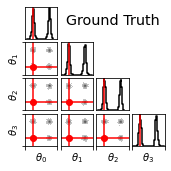

In [8]:
dfs = swyft.utils.get_df_dict_from_marginals(ref_marginals)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="Ground Truth",
    x=0.35,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-ref-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 46.28it/s]


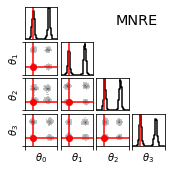

In [9]:
swy_s = gen_eggbox['swyft/nsims-10000']
dfs = swyft.utils.get_df_dict_from_weighted_marginals(swy_s)
# dfs = keyfilter(lambda x: x in [(0,), (1,), (0, 1)], dfs)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="MNRE",
    x=0.63,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-mnre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 51.85it/s]


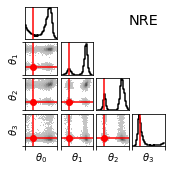

In [10]:
nre_s = gen_eggbox['sbi/nsims-10000']
marginals = tmnre.marginalize.all_marginals(nre_s)
dfs = swyft.utils.get_df_dict_from_marginals(marginals)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="NRE",
    x=0.7,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-nre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 45.61it/s]


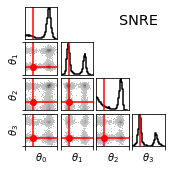

In [11]:
nre_s = gen_eggbox['seq/nsims-10000']
marginals = tmnre.marginalize.all_marginals(nre_s)
dfs = swyft.utils.get_df_dict_from_marginals(marginals)
dfs = keyfilter(keep, dfs)
fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="SNRE",
    x=0.65,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-snre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 40.96it/s]


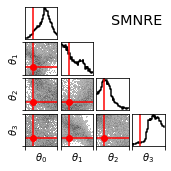

In [12]:
dfs = swyft.utils.get_df_dict_from_marginals(seq_eggbox)
dfs = keyfilter(keep, dfs)
fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="SMNRE",
    x=0.6,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-msnre-corner.png", **save_kwargs)